<a href="https://colab.research.google.com/github/merrouchi37/ConvCoroNet/blob/main/Covid_19_training_K_Fold_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/app")

Mounted at /content/drive/


In [ ]:
!pip install mlxtend --upgrade --no-deps

     |████████████████████████████████| 1.3MB 11.9MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam,RMSprop, SGD
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
#import argparse
import cv2
import os
import shutil
import math

In [ ]:

data_train = np.load('data_train_p_224.npy')
labels_train = np.load('labels_train_p_224.npy')


In [ ]:
data_train.shape

(1500, 224, 224, 3)

In [ ]:
#Shuffling Data
indx=np.arange(data_train.shape[0])          
np.random.shuffle(indx)
data_train = data_train[indx]
labels_train = labels_train[indx]

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15
  
	)

In [ ]:
def create_model( ):
  
  baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
  x = baseModel.output
  x = Flatten(name="flatten")(x)
  x = Dropout(0.45)(x)
  x = Dense(256)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.45)(x)
  x = Dense(3, activation="softmax")(x)

  model = Model(inputs=baseModel.input, outputs=x)
  for layer in baseModel.layers: 
    layer.trainable = True
  
  opt = SGD(lr=0.0)
  print("[INFO] compiling model...")
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])
  return model
  

In [ ]:
model = create_model()
model.summary()

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)

In [ ]:
labels = np.argmax(labels_train, axis=1)

In [ ]:
labels.shape

(1500,)

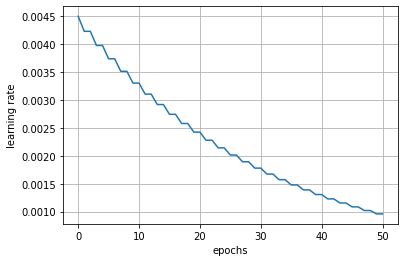

In [ ]:
class StepDecay():
	def __init__(self, initAlpha=0.002, factor=0.5, dropEvery=10):
		# store the base initial learning rate, drop factor, and
		# epochs to drop every
		self.initAlpha = initAlpha
		self.factor = factor
		self.dropEvery = dropEvery
	def __call__(self, epoch):
		# compute the learning rate for the current epoch
		exp = np.floor((1 + epoch) / self.dropEvery)
		alpha = self.initAlpha * (self.factor ** exp)
		# return the learning rate
		return float(alpha)
  
num_epochs = 50
scheduler = StepDecay(initAlpha=0.0045, factor=0.94, dropEvery=2)
plt.plot(tensorflow.range(num_epochs+1), [scheduler(t) for t in range(num_epochs+1)])
plt.xlabel("epochs")
plt.ylabel("learning rate")
plt.grid(True)
plt.show()

In [ ]:
tensorflow.keras.backend.clear_session()

In [ ]:
!mkdir covid19_models_cross_val8

mkdir: cannot create directory ‘covid19_models_cross_val8’: File exists


In [ ]:
# Training ConvCoroNet using k-fold cross-validation
from utils import plot_acc_loss
from utils import evaluation_metrics

validation_accuracy = []
validation_loss = []

base_model = "InceptionV3"
save_dir = 'covid19_models_cross_val8/'
fold_var = 1
for train_index, val_index in skf.split(np.zeros(len(data_train)),labels):
  
  training_data = data_train[train_index]
  training_labels = labels_train[train_index]
  validation_data = data_train[val_index]
  validation_labels = labels_train[val_index]

  model = create_model()
  best_model_path = save_dir + 'model_' + base_model + '-' + str(fold_var) + '.h5'
  mcp_save = ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_acc', mode='max', verbose=1)
  scheduler = StepDecay(initAlpha=0.0045, factor=0.94, dropEvery=2)
  lrs = LearningRateScheduler(scheduler)
  callbacks = [ mcp_save, lrs]
  print("[INFO] training K-Fold...step: " + str(fold_var))
  EPOCHS=50
  BS_tr=10
  BS_val = 10
  H = model.fit_generator(
    trainAug.flow(training_data, training_labels, batch_size=BS_tr),
    steps_per_epoch=len(training_data) // BS_tr ,
    validation_data=(validation_data, validation_labels),
    validation_steps=len(validation_data) // BS_val ,
    epochs=EPOCHS, callbacks=callbacks,
    shuffle=True)
  
  np.save(save_dir + 'history_' + base_model + '-' + str(fold_var) + '.npy', H.history)
  plot_acc_loss(H, 50)

  model.load_weights(best_model_path)
  results = model.evaluate(validation_data, validation_labels)
  results = dict(zip(model.metrics_names,results))
  
  validation_accuracy.append(results['acc'])
  validation_loss.append(results['loss'])

  plt.figure()
  plt.show()

  evaluation_metrics(model, validation_data, validation_labels, fold_var, BS_val)
  
  tensorflow.keras.backend.clear_session()
    
  fold_var = fold_var + 1

In [ ]:
print(validation_accuracy)
print(validation_loss)

[0.9833333492279053, 0.9933333396911621, 0.9900000095367432, 0.9833333492279053, 0.9833333492279053]
[0.07455717027187347, 0.03814205899834633, 0.04812905564904213, 0.0962536409497261, 0.07404368370771408]


In [ ]:
print(np.mean(validation_accuracy))
print(np.std(validation_accuracy))

0.9866666793823242
0.004216366192513858
